In [2]:
import numpy as np
import json, os, sys, glob
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping
tf.keras.backend.clear_session()

cur_path=os.getcwd()
sys.path.append(cur_path)

parent_path=os.path.abspath(os.path.join(cur_path,'..'))
sys.path.append(parent_path)

### Load Data

In [3]:
%load_ext autoreload
%autoreload 2

from load_data import load_sig_tensor

folder_path = r'C:\Users\MichaelB9\Documents\POSA data\S9 AHI\json_files\preprocessed'

target_signal='Position'
input_signals=['Flow']

json_files = glob.glob(os.path.join(folder_path,'*.json'))

sig_tensor, target_tensor, subject_names = load_sig_tensor(
    json_files,epoch_size = 60,epoch_step = 30,
    sample_rate = 25, input_signals=input_signals,
    target_signal=target_signal,
    dataset='s9',
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plot octave encoded signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


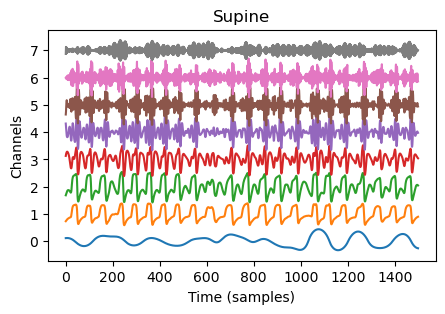

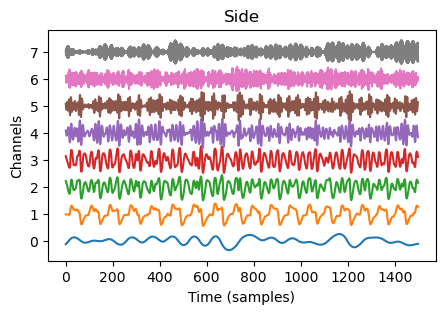

In [58]:
%load_ext autoreload
%autoreload 2
from plotting import plot_oct

plot_oct(sig_tensor['Flow'][:,3,:],np.where(target_tensor[3]==1,'Supine','Side'))
plot_oct(sig_tensor['Flow'][:,300,:],np.where(target_tensor[300]==1,'Supine','Side'))


### Split the data

In [ ]:
%load_ext autoreload
%autoreload 2

from load_data import split

X_train, y_train, X_val, y_val, X_test, y_test = split(sig_tensor['Flow'],target_tensor,subject_names,train_size=0.85,val_size=0.075,test_size=0.075)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------------------------------
Train-test-validation split
------------------------------
Training Set Size =  127  subjects
Validation Set Size =  11  subjects
Test Set Size =  12  subjects
------------------------------
train set size =  (93760, 1500, 8) 
 Target distribution 
 1    0.527645
0    0.472355
dtype: float64
------------------------------
val set size =  (7644, 1500, 8) 
 Target distribution 
 0    0.56214
1    0.43786
dtype: float64
------------------------------
test set size =  (8902, 1500, 8) 
 Target distribution 
 1    0.50337
0    0.49663
dtype: float64
------------------------------


In [ ]:
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()

from build_dnns import build_cnn_1D

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

# Build model
cnn_model=build_cnn_1D(X_train.shape[1],X_train.shape[2],filters=16,kernel_size=16,n_dense=16,dropout=0.3)
# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)    
cnn_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])
# Fit model
H=cnn_model.fit(
    X_train,y_train,
    epochs=60,batch_size=128,
    shuffle=True,validation_data=(X_val,y_val),
    # callbacks=[es],
    )

NameError: name 'tf' is not defined